In [2]:
import sys
sys.path.append("../")

from config import Config
conf = Config()

import os
from langchain.embeddings import init_embeddings


from typing import Optional 
import pandas as pd

from langgraph.graph import START, END, MessagesState, StateGraph

from langchain_core.tools import tool


from langgraph.prebuilt import create_react_agent, ToolNode
from langchain_core.messages import AIMessage  


from typing import Literal
from pydantic import BaseModel, Field

######### ENV #########
from dotenv import load_dotenv

from datetime import datetime, timedelta
from typing import Literal, Optional
from enum import Enum


load_dotenv()



True

In [3]:

class MemoryResponse(BaseModel):
    """Respond to the user with this"""

    date_logged: datetime = Field(description = "Logging the date and time you set this memory")
    remember_window: datetime = Field(description="Remember upto the provided minute, hour, day, week, month, year or permanently")
    remember_flag: str = Field(description= "Return exactly : Permanent or Not Permanent")
    AImessage : str = Field(description="Final AI Message reminding the user of the memory. Always mention the date in english")
    context: str = Field(description="The context you want to save")


class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: MemoryResponse


class TimePeriod(str, Enum):
    MINUTE = "minute"
    HOUR = "hour"
    DAY = "day"
    WEEK = "week"
    MONTH = "month"
    YEAR = "year"
    PERMANENTLY = "permanently"
    SPECIFIC_DATE = "specific_date"
    SPECIFIC_DAY = "specific_day"


@tool
def extract_goal_from_string(context: str):
    """This is function to extract the context to remember from the user query"""
    return context

@tool
def extract_date_logged(context: str):
    """This is function to extract the date to be logged"""
    return datetime.now()


@tool
def extract_end_beginning_flag(context: str) -> Literal["beginning", "end"]:
    """Extracts whether the context refers to the 'beginning' or 'end' of a time period (minute/hour/day/week/month/year). 
    Returns only these two exact words based on keywords in the input."""
    context_lower = context.lower()
    
    # Check for end-related keywords first (more specific)
    if any(word in context_lower for word in ["end", "last", "final", "closing", "conclusion", "tail end", "this"]):
        return "end"
    
    # Default to beginning (also catches start/beginning/first/etc.)
    return "beginning"


@tool
def remember_window(
    remember_window_flag: TimePeriod,
    n: int = 0,
    end_or_beginning_flag: Literal["beginning", "end"] = "end",
    specific_date: Optional[str] = None,
    specific_day: Optional[str] = None
) -> datetime:
    """
    Calculate exact datetime for reminder windows with natural language support
    Handles: minutes, hours, days, weeks, months, years, specific dates, specific days
    """
    current = datetime.now()
    
    def set_time_boundary(dt: datetime, boundary: str) -> datetime:
        """Set to start or end of time period"""
        if boundary == 'end':
            return dt.replace(hour=23, minute=59, second=59, microsecond=999999)
        return dt.replace(hour=0, minute=0, second=0, microsecond=0)
    
    # Handle permanent memory
    if remember_window_flag == TimePeriod.PERMANENTLY:
        return datetime.max
    
    # Handle specific date (YYYY-MM-DD)
    if remember_window_flag == TimePeriod.SPECIFIC_DATE and specific_date:
        try:
            target = datetime.strptime(specific_date, "%Y-%m-%d")
            return set_time_boundary(target, end_or_beginning_flag)
        except ValueError:
            return set_time_boundary(current, end_or_beginning_flag)
    
    # Handle specific day (e.g., "Thursday")
    if remember_window_flag == TimePeriod.SPECIFIC_DAY and specific_day:
        days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
        try:
            target_day_index = days.index(specific_day.lower())
            current_day_index = current.weekday()
            
            # Calculate days until target day
            days_forward = (target_day_index - current_day_index) % 7
            # Handle "next <day>" semantics
            if n > 0 or days_forward == 0:
                days_forward += 7 * max(n, 1)
            
            target = current + timedelta(days=days_forward)
            return set_time_boundary(target, end_or_beginning_flag)
        except ValueError:
            return set_time_boundary(current, end_or_beginning_flag)
    
    # Relative time periods
    if remember_window_flag == TimePeriod.MINUTE:
        target = current + timedelta(minutes=n)
        if end_or_beginning_flag == 'end':
            return target.replace(second=59, microsecond=999999)
        return target.replace(second=0, microsecond=0)
    
    if remember_window_flag == TimePeriod.HOUR:
        target = current + timedelta(hours=n)
        if end_or_beginning_flag == 'end':
            return target.replace(minute=59, second=59, microsecond=999999)
        return target.replace(minute=0, second=0, microsecond=0)
    
    if remember_window_flag == TimePeriod.DAY:
        target = current + timedelta(days=n)
        return set_time_boundary(target, end_or_beginning_flag)
    
    if remember_window_flag == TimePeriod.WEEK:
        # Calculate based on Monday as week start
        days_to_monday = current.weekday()
        start_of_week = current - timedelta(days=days_to_monday)
        
        if end_or_beginning_flag == 'end':
            end_of_week = start_of_week + timedelta(days=6)
            target = end_of_week + timedelta(weeks=n)
            return set_time_boundary(target, 'end')
        
        target = start_of_week + timedelta(weeks=n)
        return set_time_boundary(target, 'beginning')
    
    if remember_window_flag == TimePeriod.MONTH:
        # Calculate month offset
        new_year = current.year + (current.month + n - 1) // 12
        new_month = (current.month + n - 1) % 12 + 1
        
        if end_or_beginning_flag == 'beginning':
            return datetime(new_year, new_month, 1, 0, 0, 0)
        
        # Last day of month calculation
        if new_month == 12:
            next_year = new_year + 1
            next_month = 1
        else:
            next_year = new_year
            next_month = new_month + 1
        
        last_day = datetime(next_year, next_month, 1) - timedelta(days=1)
        return set_time_boundary(last_day, 'end')
    
    if remember_window_flag == TimePeriod.YEAR:
        target_year = current.year + n
        if end_or_beginning_flag == 'beginning':
            return datetime(target_year, 1, 1, 0, 0, 0)
        return datetime(target_year, 12, 31, 23, 59, 59, 999999)
    
    # Default to current time with boundary
    return set_time_boundary(current, end_or_beginning_flag)


tools = [extract_goal_from_string, remember_window, extract_date_logged, MemoryResponse]

remember_model =  conf.model.bind_tools(tools, tool_choice="any")

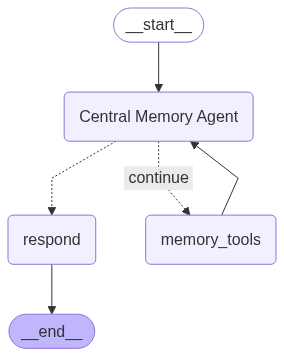

In [4]:
# Define the function that calls the model
def call_model(state: AgentState):
    response = remember_model.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function that responds to the user
def respond(state: AgentState):
    permanent_memory = pd.DataFrame()
    reminders = pd.DataFrame()
    permanent_path = f"{conf.memory_path}/Permanent_Memory.csv"
    reminders_path =  f"{conf.memory_path}/Reminders.csv"

    if os.path.exists(permanent_path):
        permanent_memory= pd.read_csv(permanent_path)

    if os.path.exists(reminders_path):
        reminders = pd.read_csv(reminders_path)
        
    # Construct the final answer from the arguments of the last tool call
    memory_tool_call = state["messages"][-1].tool_calls[0]
    response = MemoryResponse(**memory_tool_call["args"])
    # Since we're using tool calling to return structured output,
    # we need to add  a tool message corresponding to the MemoryResponse tool call,
    # This is due to LLM providers' requirement that AI messages with tool calls
    # need to be followed by a tool message for each tool call
    # Create final AI message instead of tool message
    ai_message = AIMessage(
        content=response.AImessage,
        response_metadata={"final_response": response.model_dump()}
    )
    # We return the final answer

      
    
    path = reminders_path
    central_memory = reminders
    if response.remember_flag.lower() == 'permanent':
        path = permanent_path
        central_memory = permanent_memory

    central_memory = pd.concat([central_memory, pd.DataFrame(response.model_dump(), index=[0])], ignore_index=True)
    central_memory.to_csv(path, index=False)
    return {"final_response": response, "messages": [ai_message]}

   


# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if (
        len(last_message.tool_calls) == 1
        and last_message.tool_calls[0]["name"] == "MemoryResponse"
    ):
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"
    


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("Central Memory Agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("memory_tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("Central Memory Agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "Central Memory Agent",
    should_continue,
    {
        "continue": "memory_tools",
        "respond": "respond",
    },
)

workflow.add_edge("memory_tools", "Central Memory Agent")
workflow.add_edge("respond", END)

central_memory_agent = workflow.compile()
central_memory_agent.name = 'Central Memory Agent'
central_memory_agent

In [5]:
answer = central_memory_agent.invoke(input={"messages": [("human", "Remind me to finish things before July")]})[
    "final_response"
]

answer

MemoryResponse(date_logged=datetime.datetime(2025, 6, 28, 2, 38, 11, 430198), remember_window=datetime.datetime(2023, 6, 30, 23, 59, 59, 999999), remember_flag='Not Permanent', AImessage='You asked to be reminded to finish things before the end of June 2023.', context='finish things before July')

In [6]:
answer = central_memory_agent.invoke(input={"messages": [("human", "Remember My Name is Siddharth")]})[
    "final_response"
]

answer

MemoryResponse(date_logged=datetime.datetime(2025, 6, 28, 2, 38, 21), remember_window=datetime.datetime(9999, 12, 31, 23, 59, 59), remember_flag='Permanent', AImessage="I've remembered that your name is Siddharth permanently.", context='Remember My Name is Siddharth')

In [36]:
answer = central_memory_agent.invoke(input={"messages": [("human", "Remember that I am a Data Scientist")]})[
    "final_response"
]

answer

MemoryResponse(date_logged=datetime.datetime(2025, 6, 23, 3, 23, 3, 357890), remember_window=datetime.datetime(9999, 12, 31, 23, 59, 59, 999999), remember_flag='Permanent', AImessage='I will remember that you are a Data Scientist permanently. This information was logged on June 23, 2025, at 03:23 AM.', context='Remember that I am a Data Scientist')

In [10]:
# Helper Function 
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {"messages": [("user", "Remember to finish documents till Tuesday")]}
print_stream(central_memory_agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Remember to finish documents till Tuesday
================================== Ai Message ==================================
Tool Calls:
  extract_goal_from_string (call_G0ZL8ZVyAry4MNzXcsN7aJtj)
 Call ID: call_G0ZL8ZVyAry4MNzXcsN7aJtj
  Args:
    context: Remember to finish documents till Tuesday
  extract_date_logged (call_iZGJcAYthpNGDXsXyNrKuyLS)
 Call ID: call_iZGJcAYthpNGDXsXyNrKuyLS
  Args:
    context: Remember to finish documents till Tuesday
================================= Tool Message =================================
Name: extract_date_logged

2025-06-23 01:31:45.065812
================================== Ai Message ==================================
Tool Calls:
  remember_window (call_WA6t2VUmi22OSnWkyNaVEbG8)
 Call ID: call_WA6t2VUmi22OSnWkyNaVEbG8
  Args:
    remember_window_flag: specific_day
    specific_day: Tuesday
================================= Tool Message ==========================